# CCIC GridSat: Spatial coverage

This notebook analyzes the spatial coverage of the CCIC retrievals derived from GridSat data. The coverage in the first years of the data record is faily irregular und remains incomplete up until the 90s. This notebook aims to identify a spatial region that maximizes the temporal extent of the record of robust observations.

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
plt.style.use("../ccic.mplstyle")

## Calculate counts of valid retrieval values

The monthly mean files contain the number of valid retrieval values used to calculate the monthly means at every grid point stratified by the hour of the day. The code below loads the counts from the monthly result files, calculates zonal and meriodional averages, and aggregates data to obtain yearly statistics.

In [2]:
DATA_PATH = Path("/scratch/ccic_record/data/")
gridsat_files = sorted(list((DATA_PATH / "ccic" / "gridsat").glob("*.nc")))
print(f"Found {len(gridsat_files)} files.")

Found 516 files.


In [6]:
data = {
    "time": [],
    "hour_of_day": None,
    "counts": [],
    "counts_zonal_mean": [],
    "counts_meridional_mean": []
}
for path in gridsat_files:
    with xr.open_dataset(path) as input_data:
        
        month = input_data.month.data
        data["time"].append(month)
        
        hour_of_day = input_data.hour_of_day.data.astype("timedelta64[m]")
        data["hour_of_day"] = hour_of_day
        
        counts = input_data.tiwp_stratified_count.data
        data["counts"].append(counts)
        counts_zonal_mean = input_data.tiwp_stratified_count.mean("longitude").data
        data["counts_zonal_mean"].append(counts_zonal_mean)
        counts_meridional_mean = input_data.tiwp_stratified_count.mean("latitude").data
        data["counts_meridional_mean"].append(counts_meridional_mean)
        data["longitude"] = input_data.longitude.data
        data["latitude"] = input_data.latitude.data
        
counts = xr.Dataset({
    "time": (("time"), np.concatenate(data["time"])),
    "hour_of_day": (("hour_of_day",), np.array(data["hour_of_day"])),
    "longitude": (("longitude",), data["longitude"]),
    "latitude": (("latitude",), data["latitude"]),
    "counts": (("time", "hour_of_day", "latitude", "longitude"), np.stack(data["counts"])),
    "counts_zonal_mean": (("time", "hour_of_day", "latitude"), np.stack(data["counts_zonal_mean"])),
    "counts_meridional_mean": (("time", "hour_of_day", "longitude"), np.stack(data["counts_meridional_mean"])),
})

/tmp/ipykernel_2268484/2699529395.py:26: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  counts = xr.Dataset({


Aggregate data to obtain yearly statistics.

In [7]:
yearly_counts = counts.resample(time="1YE").mean()

## Visualize the results

### Timelines of zonal and meridional coverage


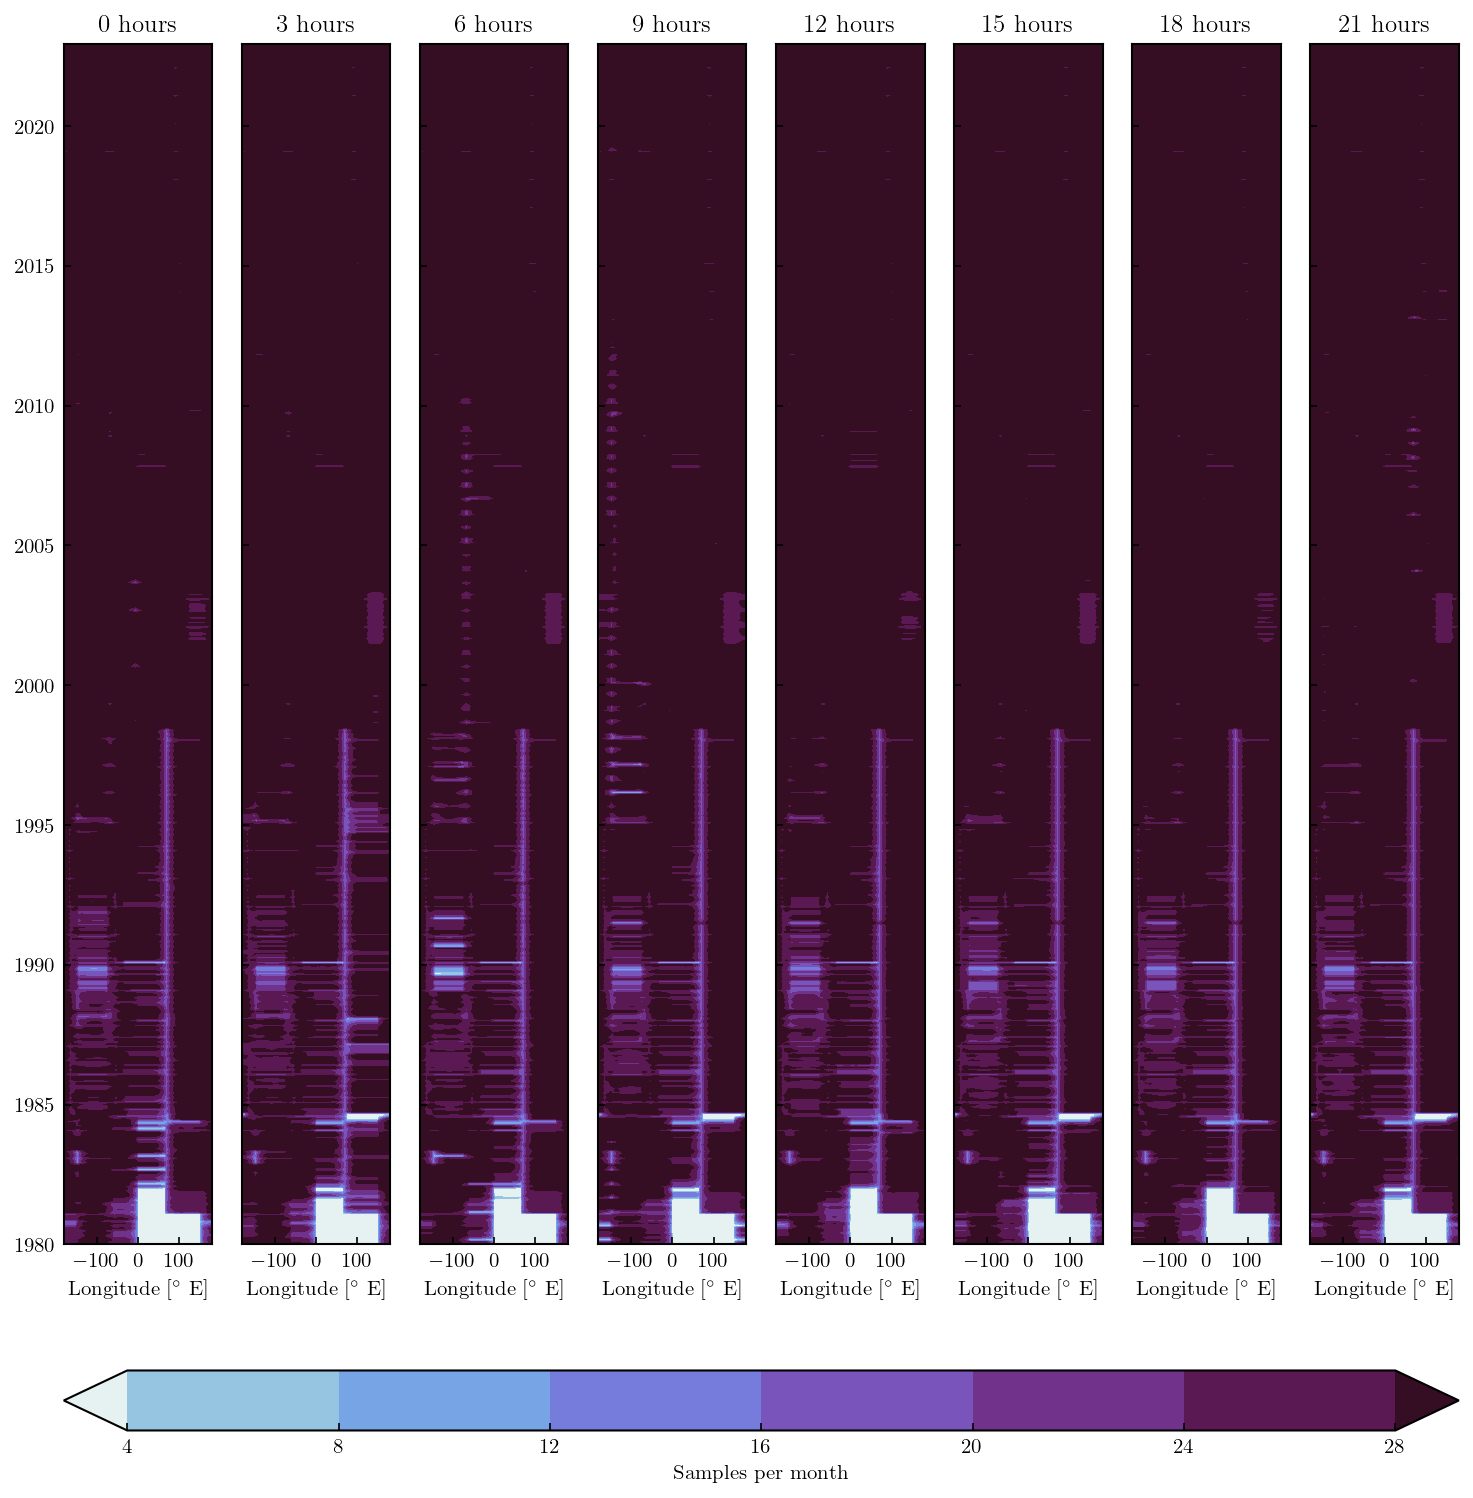

In [10]:
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(2, 8, height_ratios=[1.0, 0.05])
norm = Normalize(0, 30)

for ind in range(8):
    ax = fig.add_subplot(gs[ind])
    results = counts[{"hour_of_day": ind}]
    cnts = results.counts_meridional_mean.data
    time = results.time.data
    lon = results.longitude.data
    mappable = ax.contourf(lon, time, cnts, norm=norm, extend="both")

    hod = results.hour_of_day.data.astype("timedelta64[h]")
    ax.set_title(f"{hod}", loc="center")
    if ind > 0:
        for l in ax.yaxis.get_ticklabels():
            l.set_visible(False)
    ax.set_xlabel("Longitude [$^\circ$ E]")
    
cax = fig.add_subplot(gs[1, :])
plt.colorbar(mappable, cax=cax, label="Samples per month", orientation="horizontal")
plt.savefig("../figures/zonal_coverage_timelines.pdf", bbox_inches="tight")

The zonal coverage is almost complete by 1983 except for a gap over the Indian Ocean that persists until the 90s. There are partial coverage issues over the Americas between 1984 until 1992. For the most part thos issues affect all hours of the day similarly so should not interfere with the diurnal variability.

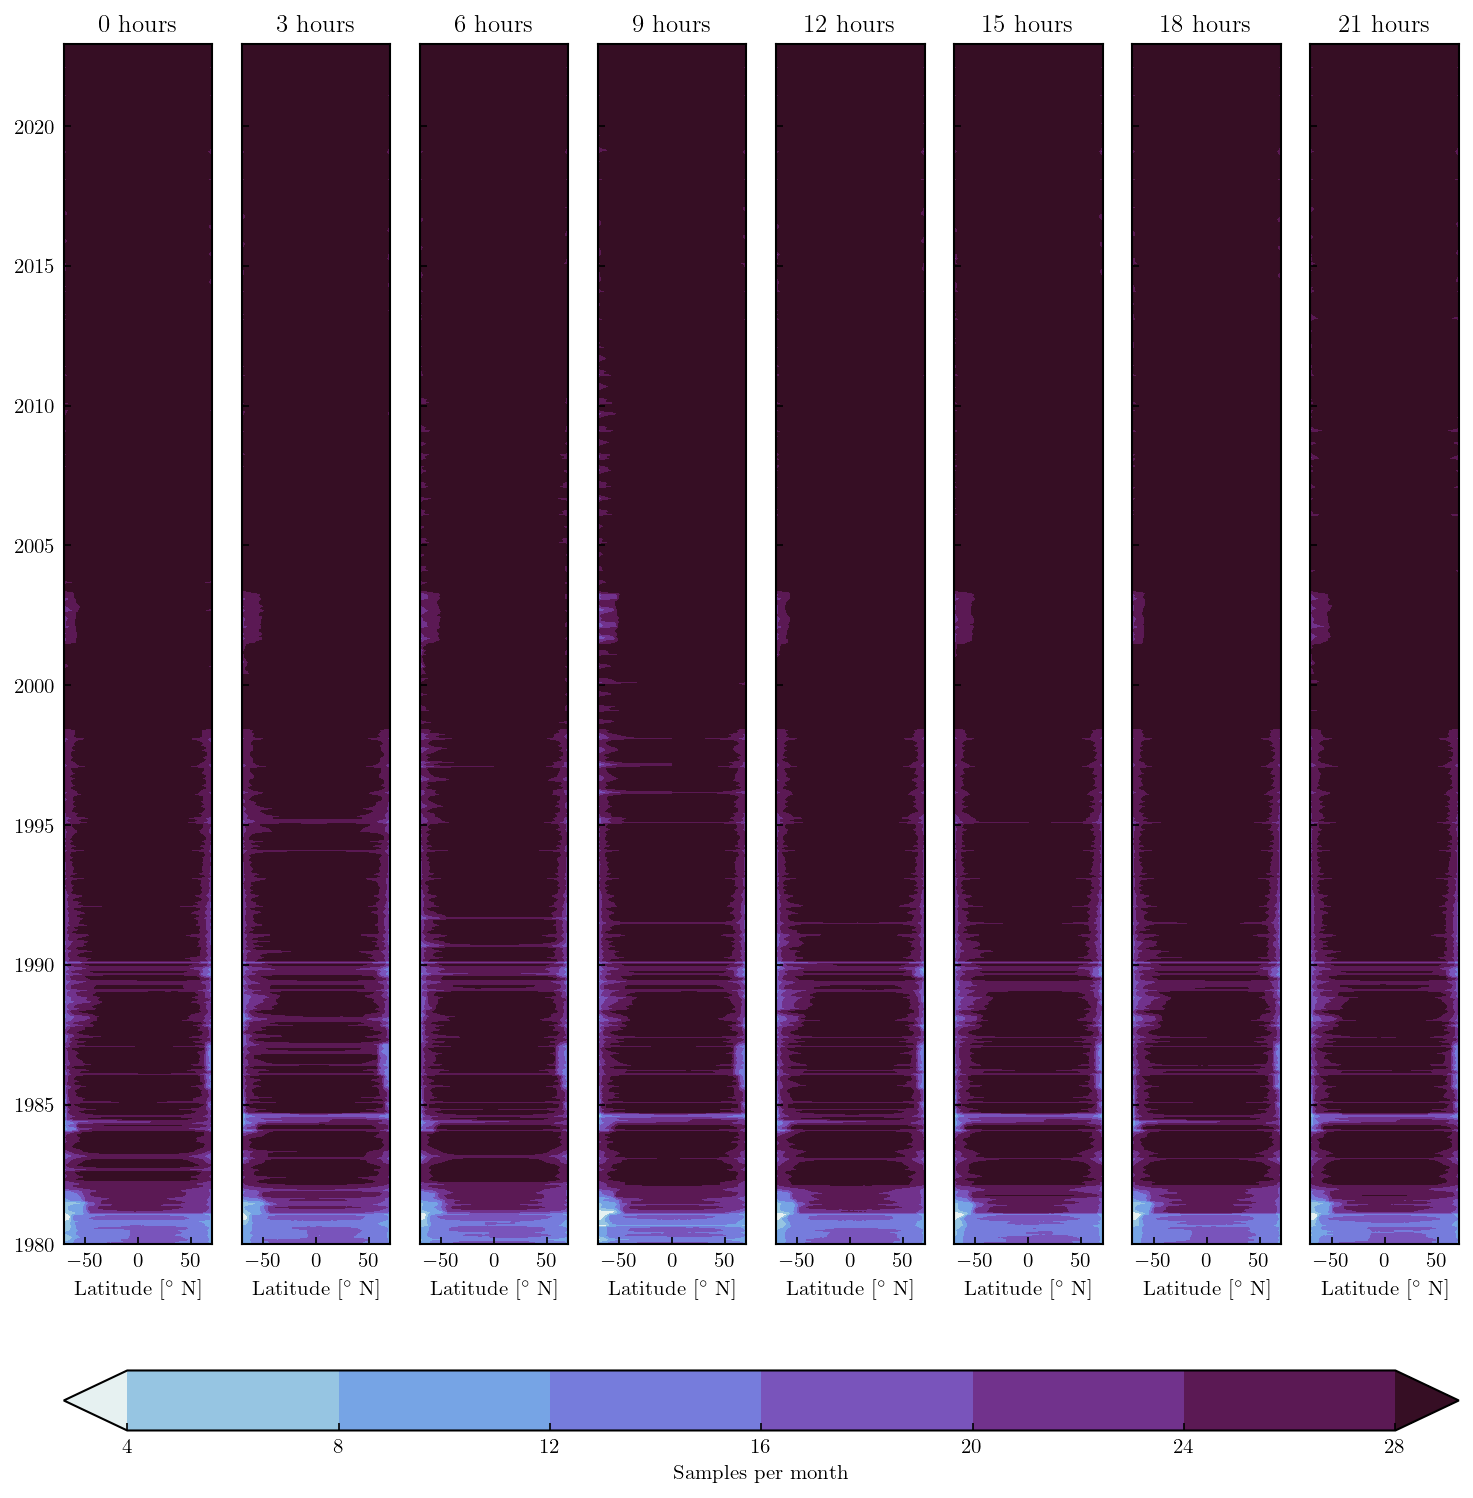

In [11]:
from matplotlib.colors import Normalize
fig = plt.figure(figsize=(12, 12))
gs = GridSpec(2, 8, height_ratios=[1.0, 0.05])
norm = Normalize(0, 30)

for ind in range(8):
    ax = fig.add_subplot(gs[ind])
    results = counts[{"hour_of_day": ind}]
    cnts = results.counts_zonal_mean.data
    time = results.time.data
    lat = results.latitude.data
    mappable = ax.contourf(lat, time, cnts, norm=norm, extend="both")

    hod = results.hour_of_day.data.astype("timedelta64[h]")
    ax.set_title(f"{hod}", loc="center")
    if ind > 0:
        for l in ax.yaxis.get_ticklabels():
            l.set_visible(False)
    ax.set_xlabel("Latitude [$^\circ$ N]")
    
cax = fig.add_subplot(gs[1, :])
plt.colorbar(mappable, cax=cax, label="Samples per month", orientation="horizontal")
plt.savefig("../figures/meridional_coverage_timelines.pdf", bbox_inches="tight")

In the first decades of the record, the number of observations tend to decrease at high latitudes. A particularly strong decrease at high latitudes of the southern hemisphere occurs during the problematic GOES years (1984 - 1992). Coverage of extreme latitude is complete from about 2000 on except for some minor reductions in coverages over the southern Pacific ocean in 2002.

### Mean monthly count distributions

In [12]:
n_years = (counts.time.max() - counts.time.min()).data.astype("timedelta64[Y]").astype(np.int64) + 1

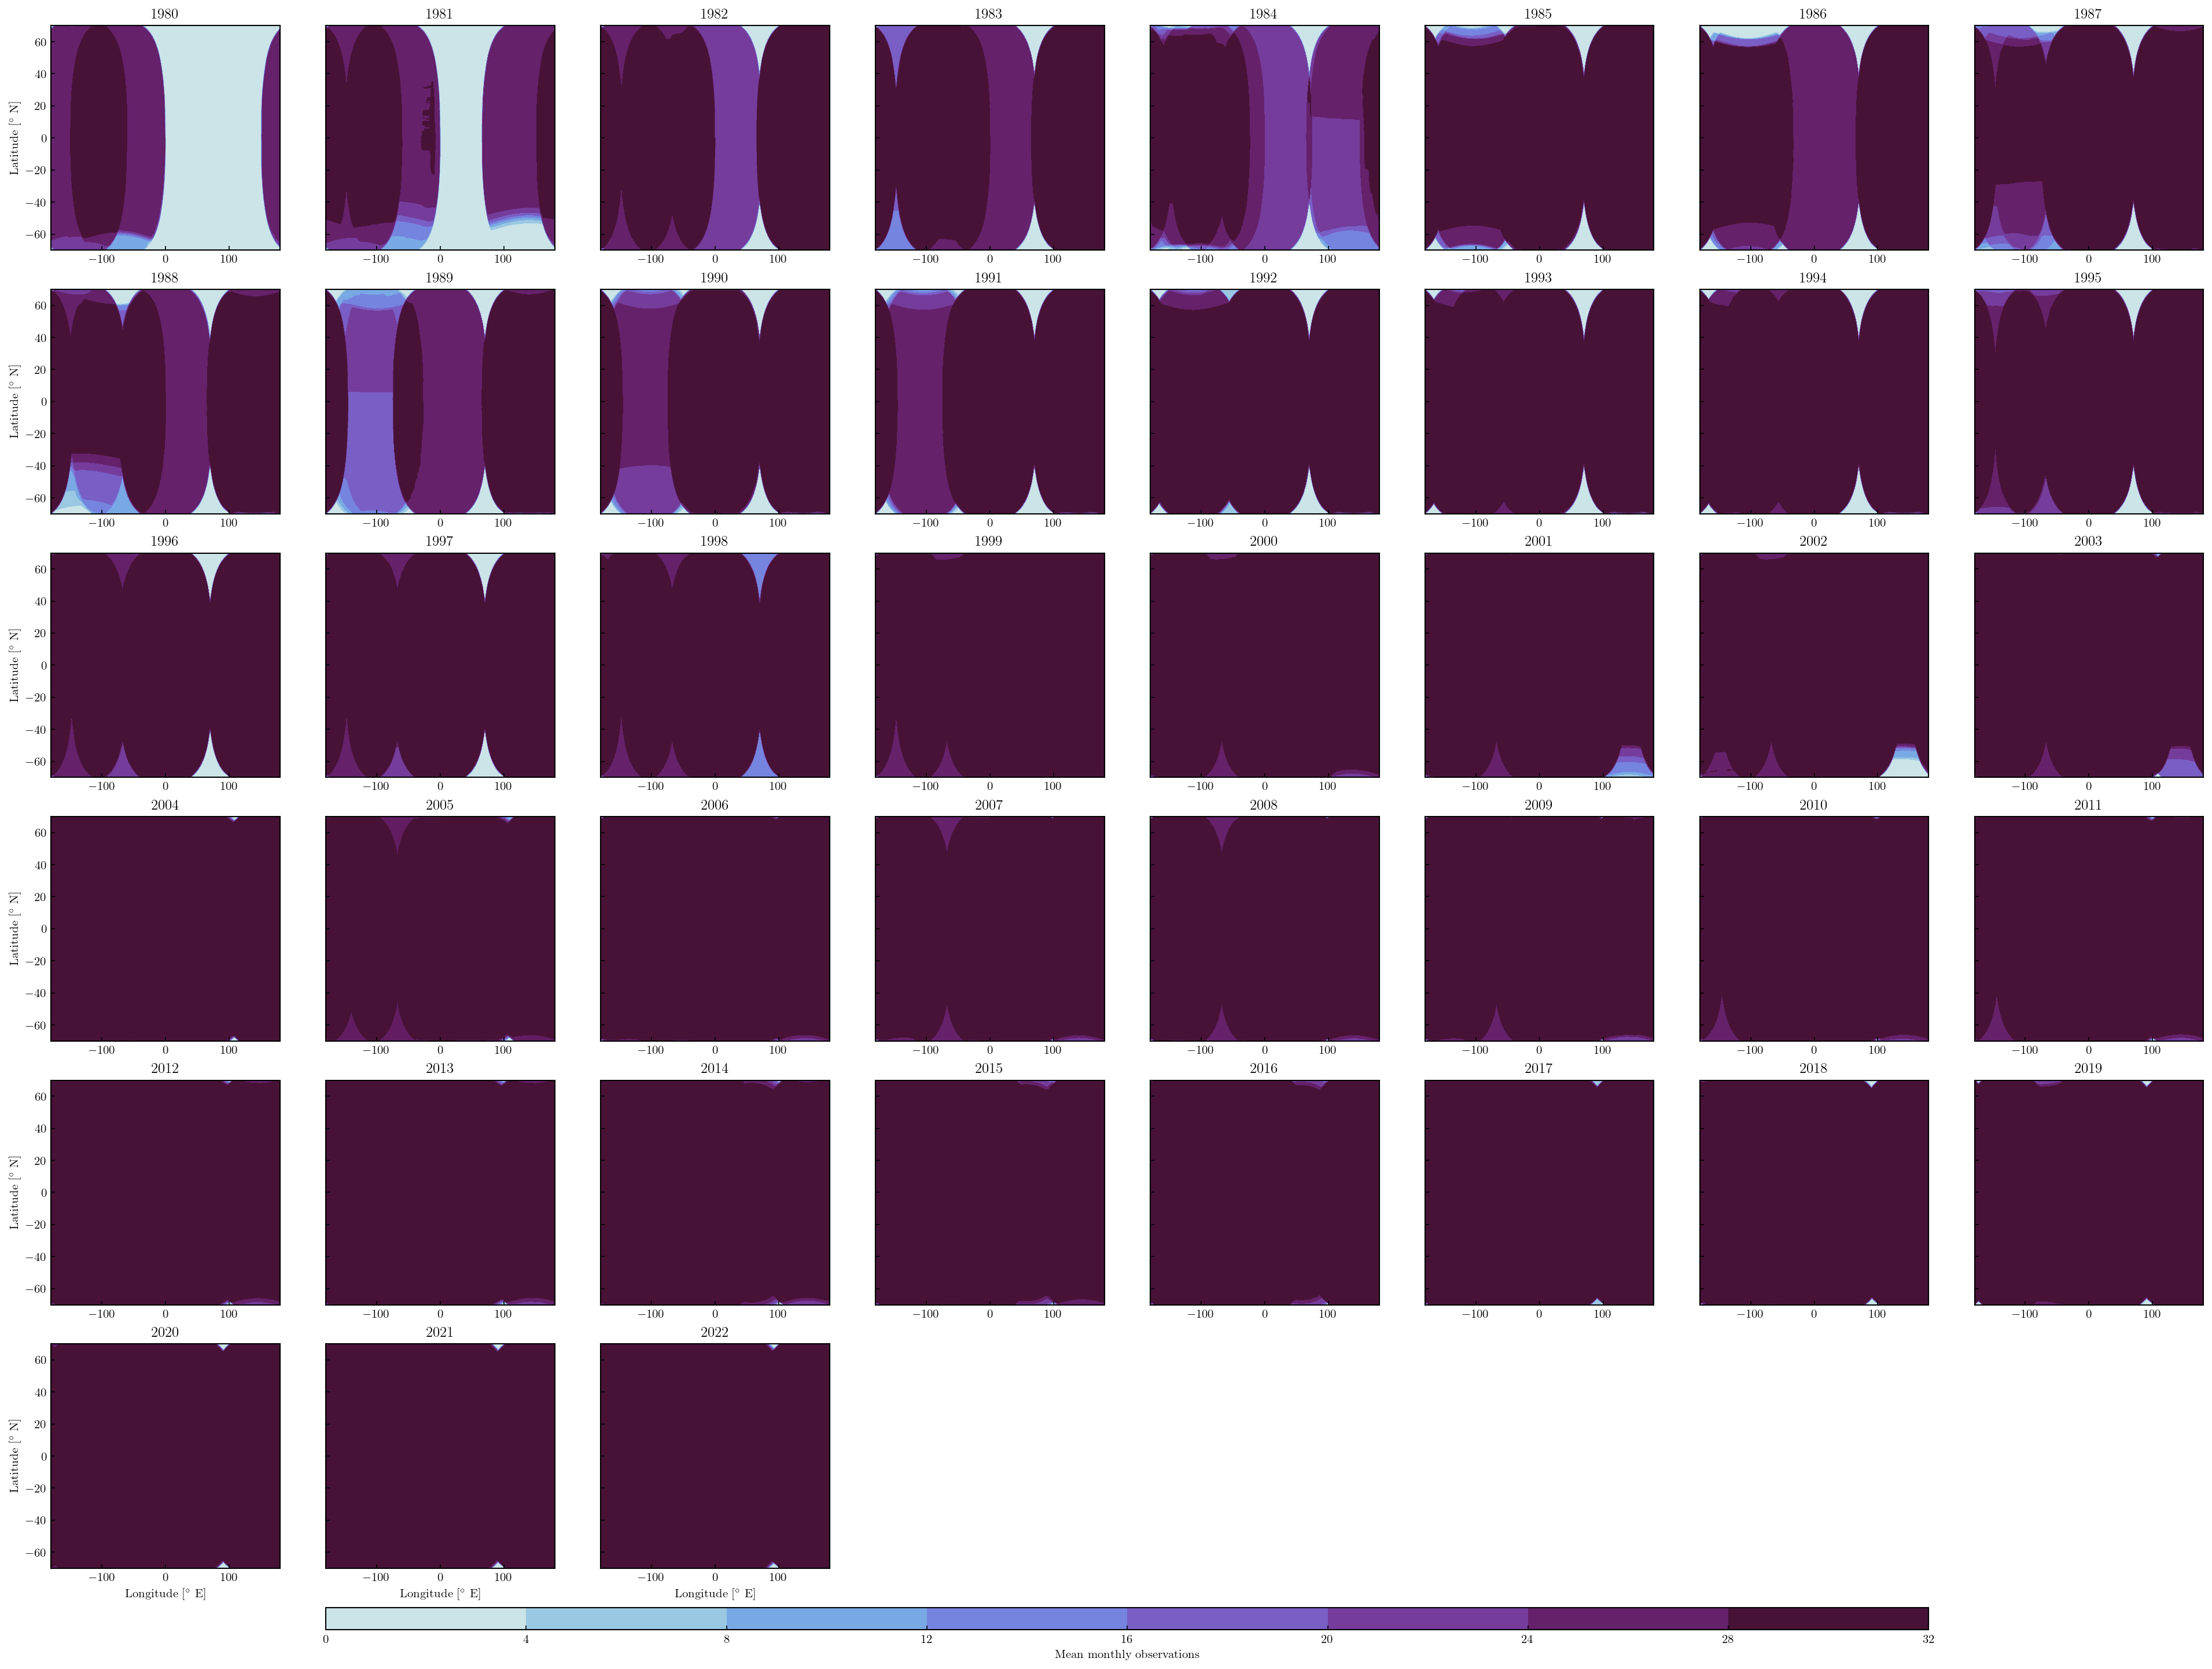

In [13]:
from math import ceil
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

N = 8
M = ceil(n_years / N)

fig = plt.figure(figsize=(N * 4, M * 4))
gs = GridSpec(M + 1, N, height_ratios=[1.0] * M + [0.1])

norm = Normalize(0, 24)
mappable = ScalarMappable(norm=norm, cmap="cmo.thermal")

for year in range(n_years):
    i = year // N
    j = year % N
    ax = fig.add_subplot(gs[year // N, year % N])
    ax.set_title(yearly_counts.time[year].dt.year.data, loc="center")
    results = yearly_counts[{"time": year}].mean("hour_of_day")
    lat = results.latitude.data
    lon = results.longitude.data
    cnts = results.counts.data
    mappable = ax.contourf(lon, lat, cnts)

    if j == 0:
        ax.set_ylabel("Latitude [$^\circ$ N]")
    else:
        ax.yaxis.set_ticklabels([])

    if i == M - 1:
        ax.set_xlabel("Longitude [$^\circ$ E]")

ax = fig.add_subplot(gs[-1, 1:-1])
plt.colorbar(mappable, cax=ax, label="Mean monthly observations", orientation="horizontal")
plt.savefig("../figures/spatial_coverage_timeline.pdf", bbox_inches="tight")

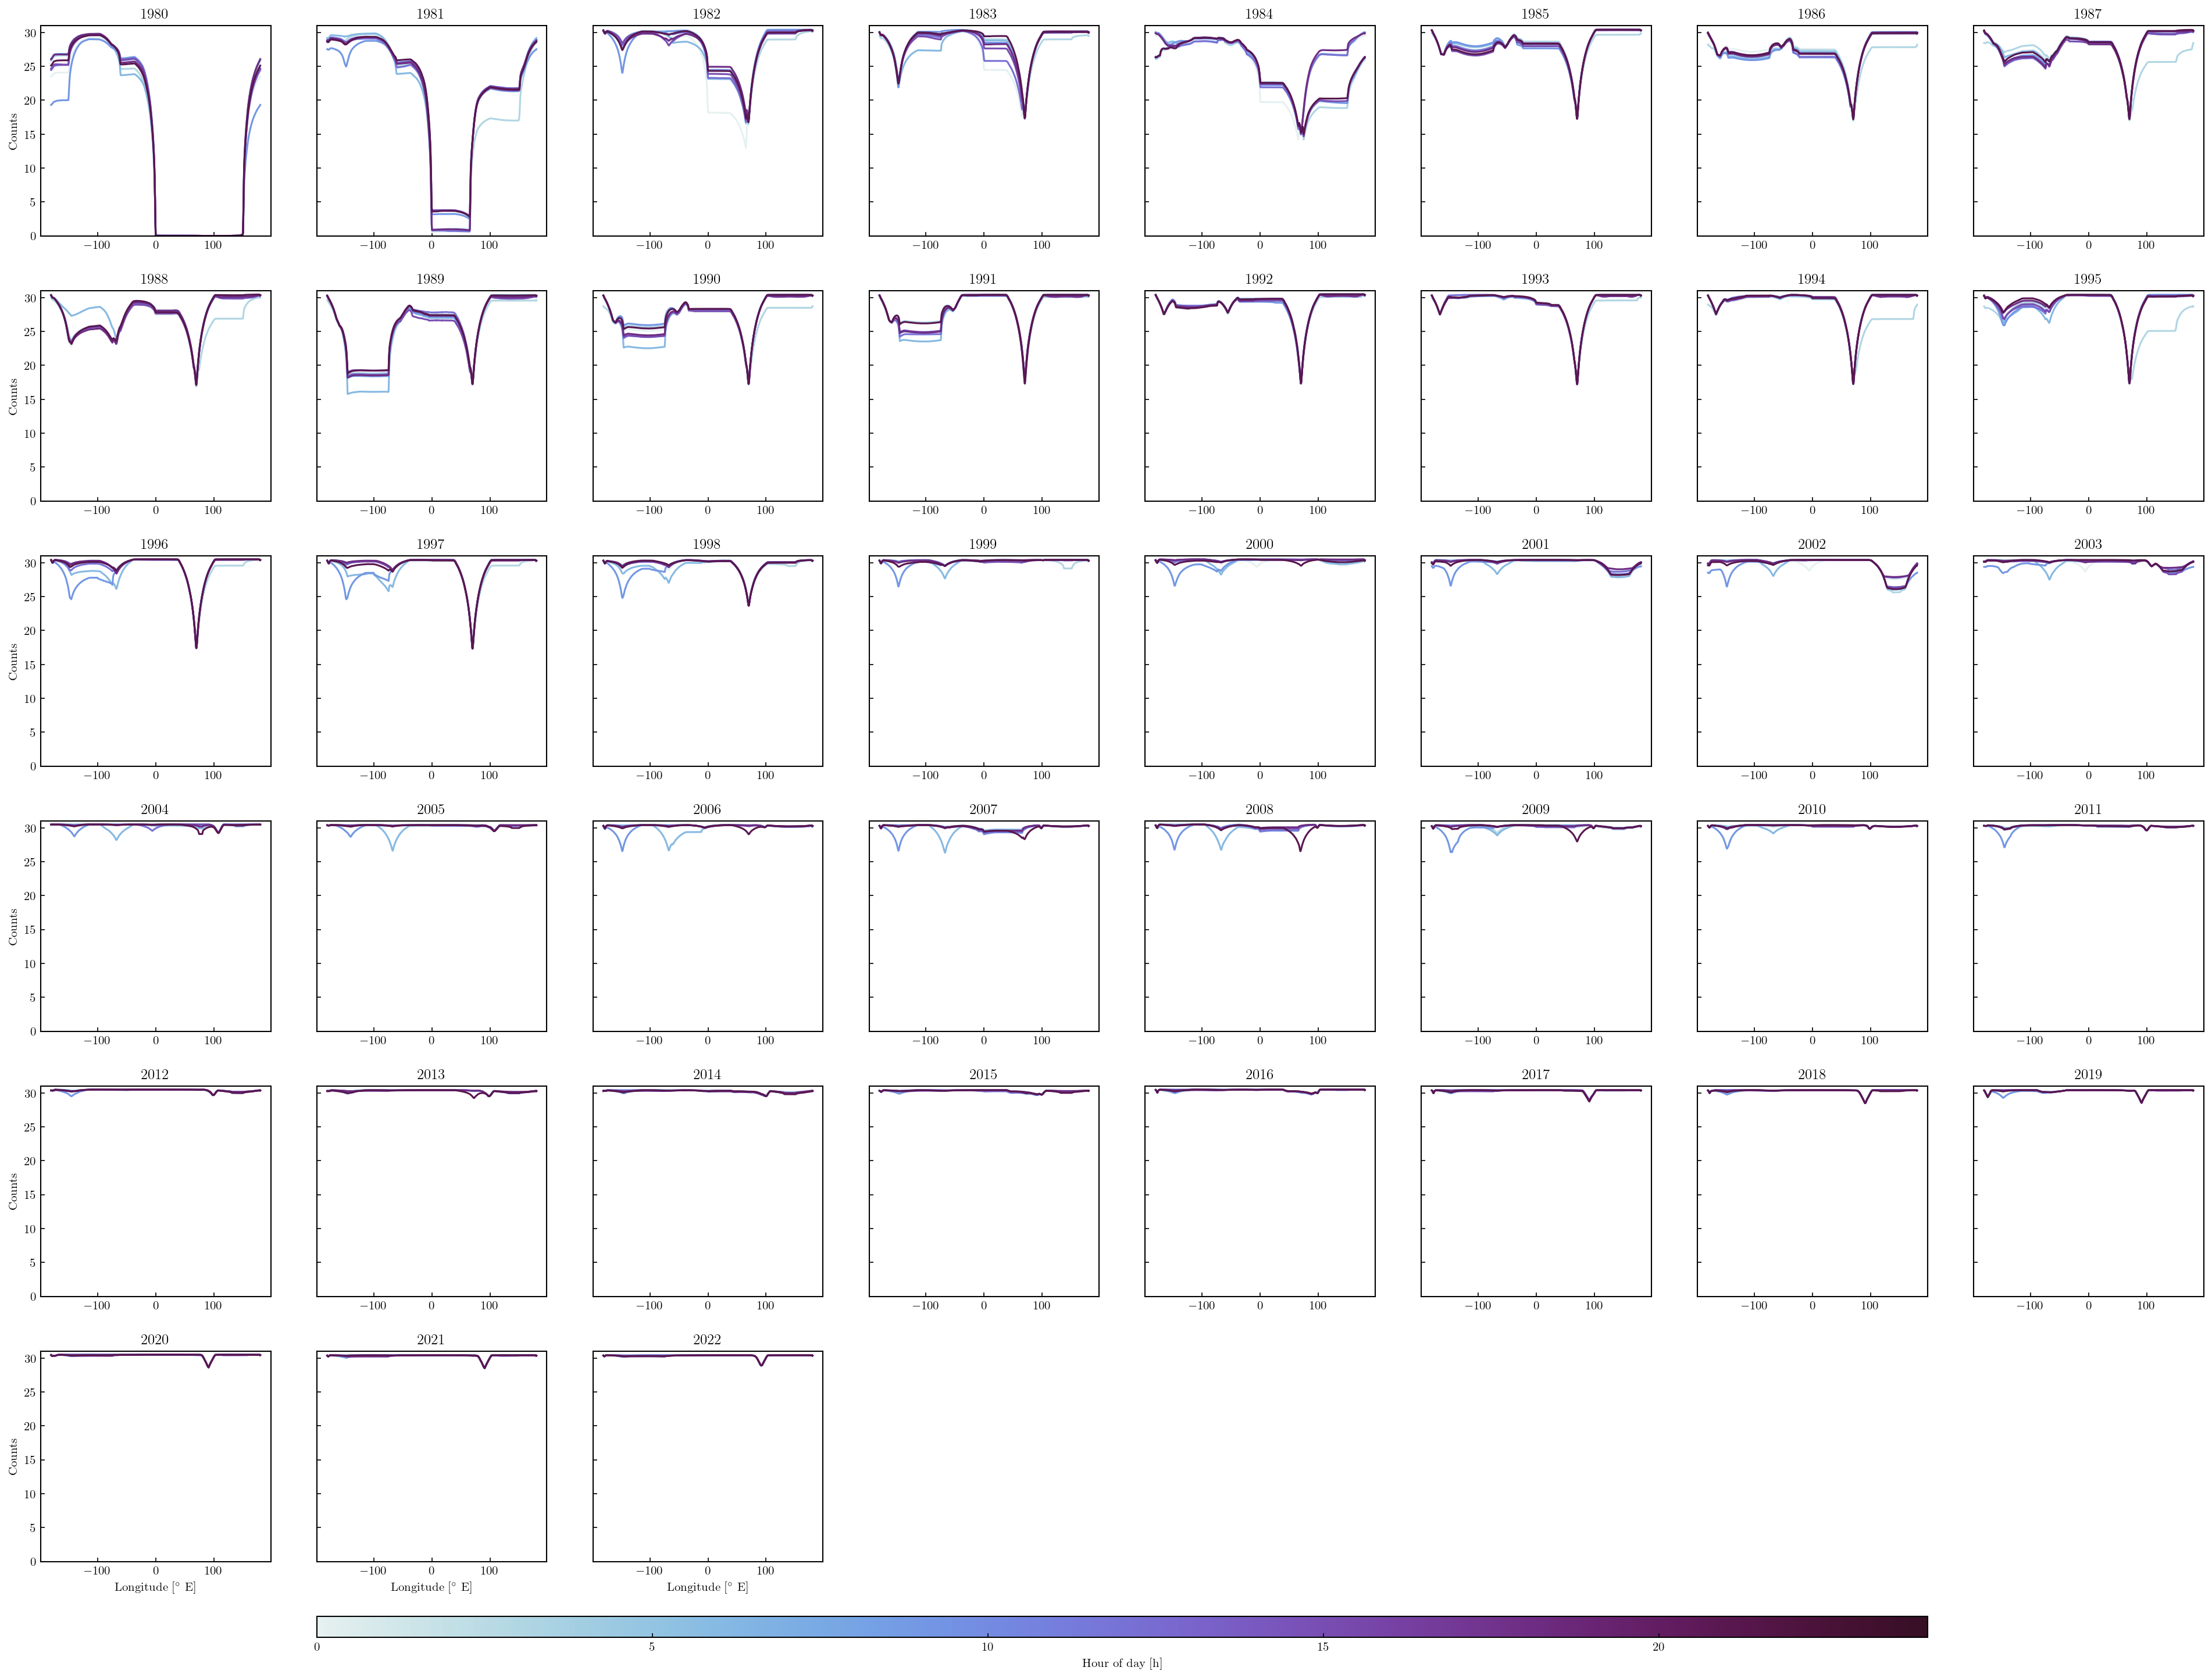

In [16]:
from math import ceil
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

N = 8
M = ceil(n_years / N)

fig = plt.figure(figsize=(N * 4, M * 4))
gs = GridSpec(M + 1, N, height_ratios=[1.0] * M + [0.1], hspace=0.3)

norm = Normalize(0, 24)
mappable = ScalarMappable(norm=norm)

for year in range(n_years):
    i = year // N
    j = year % N
    ax = fig.add_subplot(gs[year // N, year % N])
    ax.set_title(yearly_counts.time[year].dt.year.data, loc="center")
    results = yearly_counts[{"time": year}]
    lat = results.latitude.data
    lon = results.longitude.data
    for ind in range(results.hour_of_day.size):
        cnts = results.counts_meridional_mean[{"hour_of_day": ind}].data
        c = mappable.to_rgba(results.hour_of_day.data.astype("timedelta64[h]")[ind].astype("float32"))
        ax.plot(lon, cnts, c=c)
    ax.set_ylim(0, 31)

    if j == 0:
        ax.set_ylabel("Counts")
    else:
        ax.yaxis.set_ticklabels([])

    if i == M - 1:
        ax.set_xlabel("Longitude [$^\circ$ E]")

ax = fig.add_subplot(gs[-1, 1:-1])
plt.colorbar(mappable, cax=ax, label="Hour of day [h]", orientation="horizontal")
plt.savefig("../figures/zonal_coverage_diurnal_variation_timeline.pdf", bbox_inches="tight")

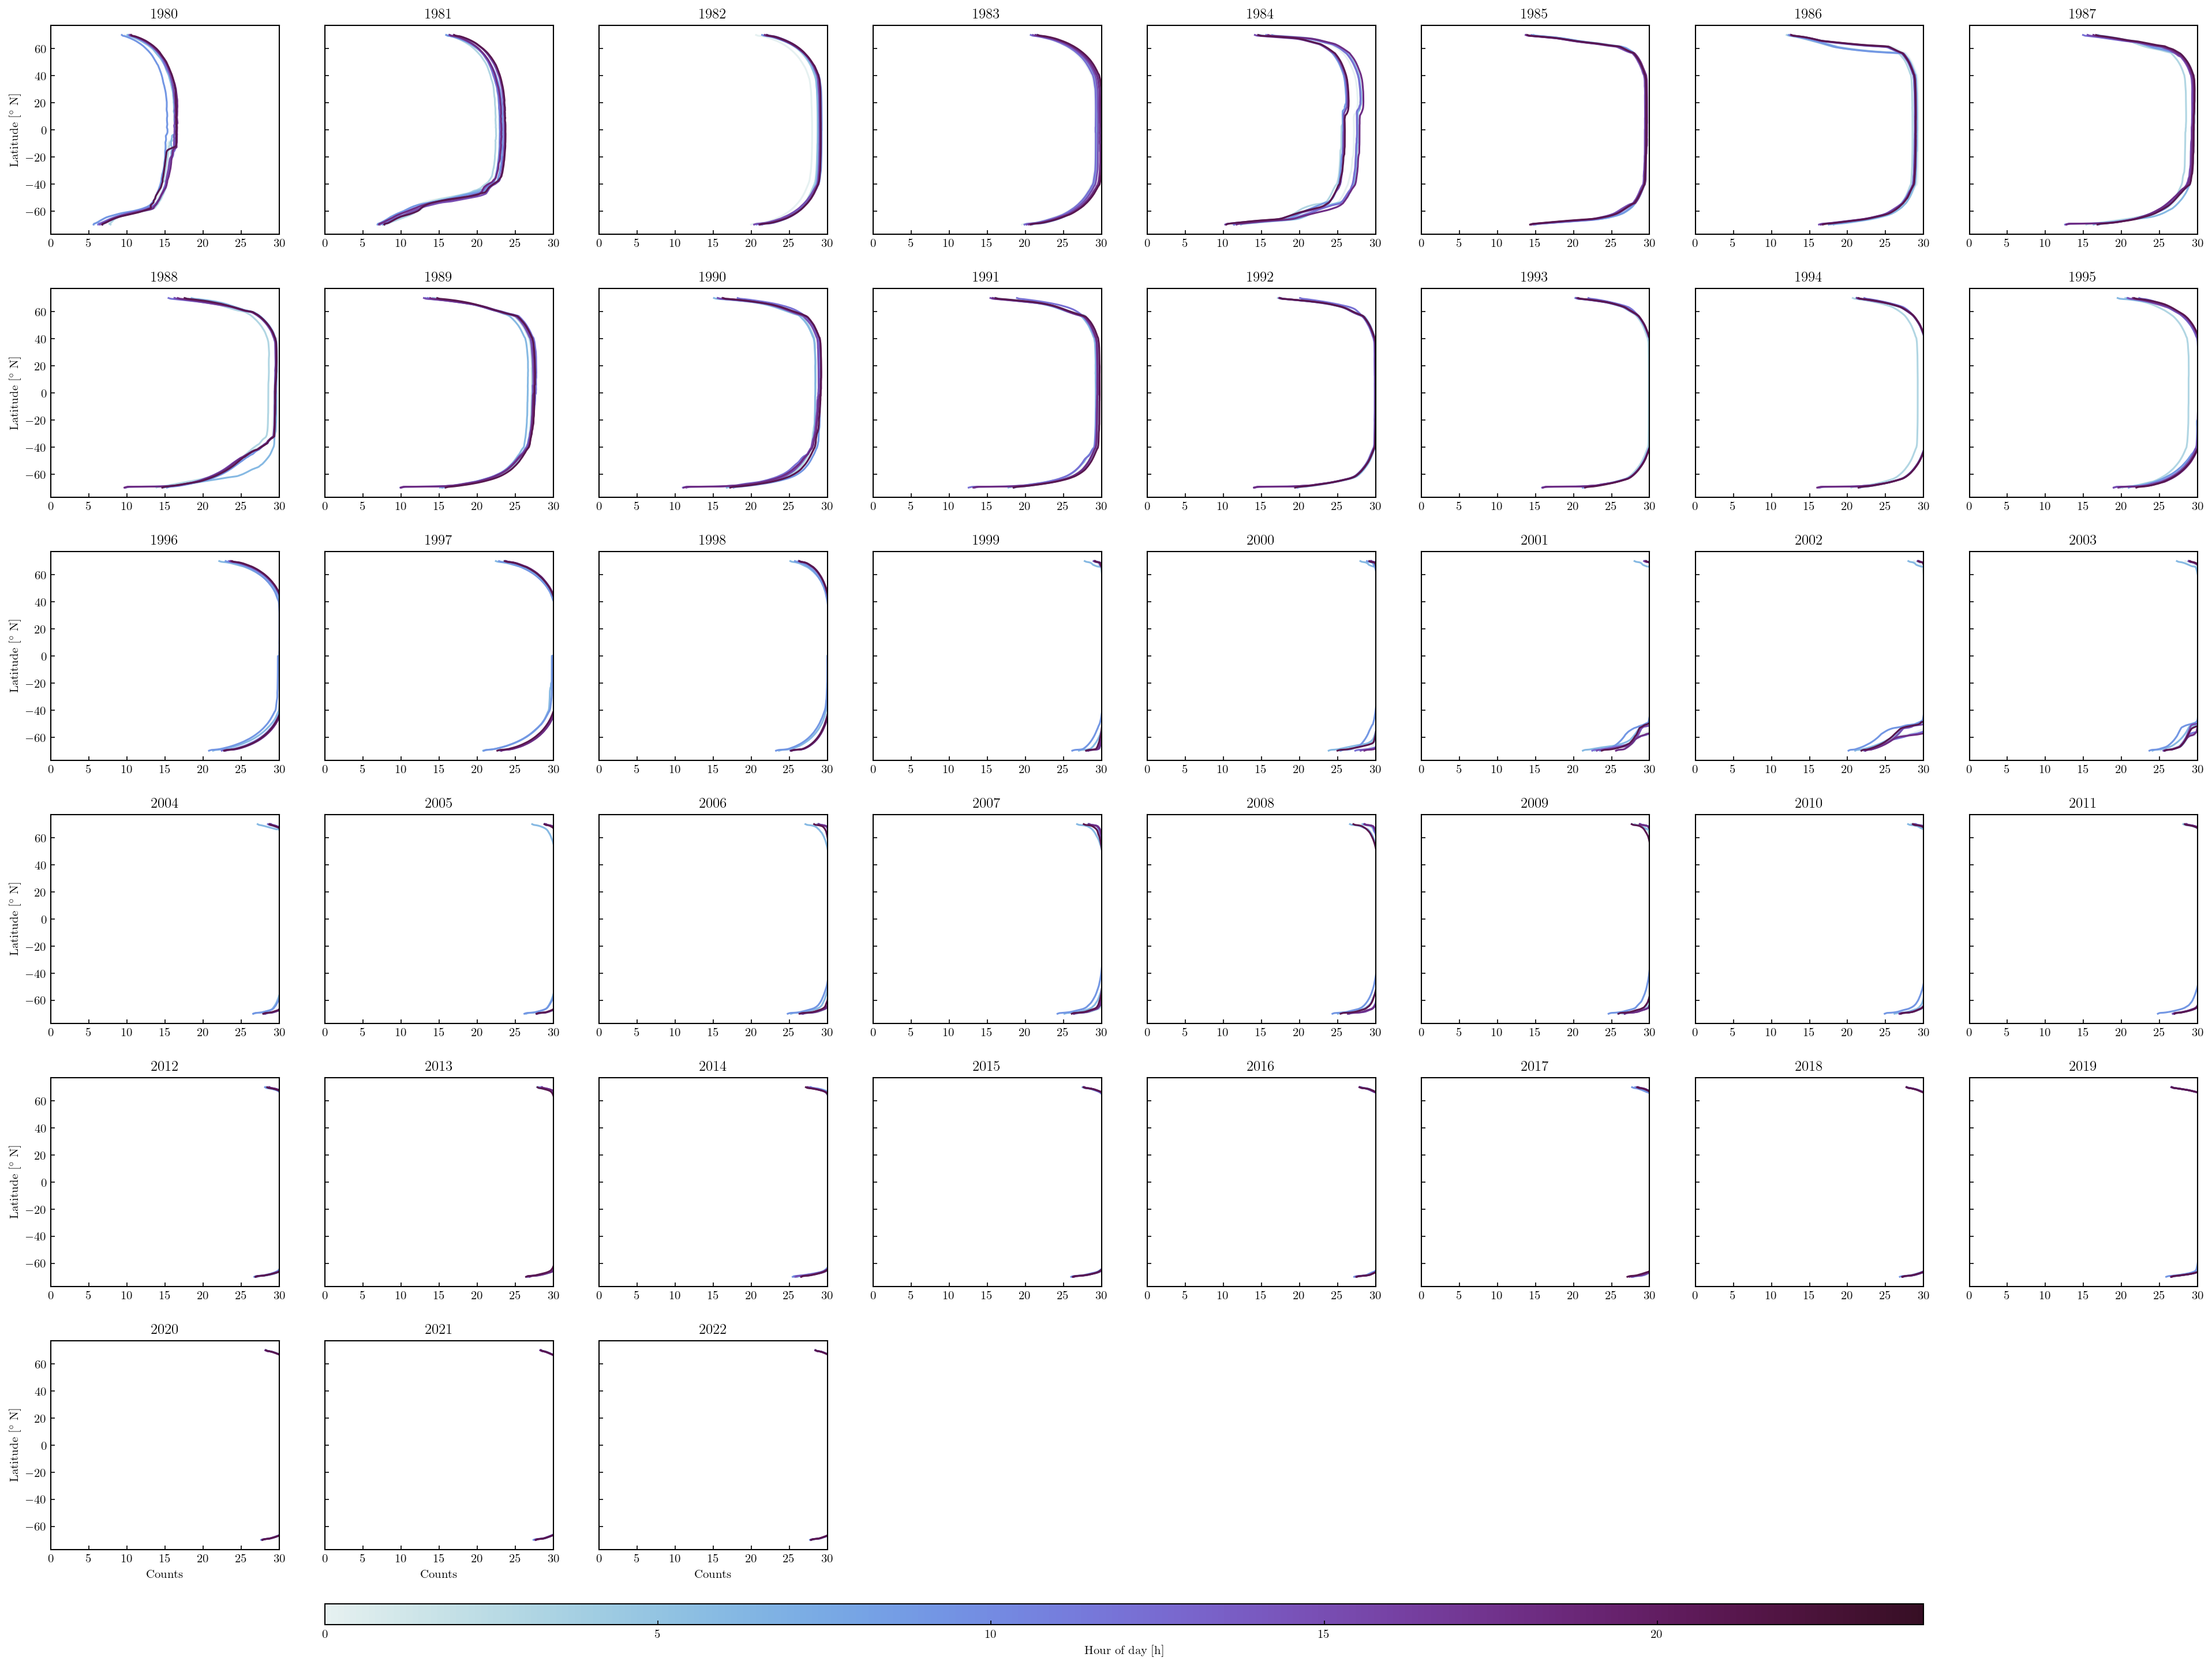

In [17]:
from math import ceil
from math import ceil
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

N = 8
M = ceil(n_years / N)

fig = plt.figure(figsize=(N * 4, M * 4))
gs = GridSpec(M + 1, N, height_ratios=[1.0] * M + [0.1], hspace=0.3)

norm = Normalize(0, 24)
mappable = ScalarMappable(norm=norm)

for year in range(n_years):
    i = year // N
    j = year % N
    ax = fig.add_subplot(gs[year // N, year % N])
    ax.set_title(yearly_counts.time[year].dt.year.data, loc="center")
    results = yearly_counts[{"time": year}]
    lat = results.latitude.data
    lon = results.longitude.data
    for ind in range(results.hour_of_day.size):
        cnts = results.counts_zonal_mean[{"hour_of_day": ind}].data
        c = mappable.to_rgba(results.hour_of_day.data.astype("timedelta64[h]")[ind].astype("float32"))
        ax.plot(cnts, lat, c=c)
    ax.set_xlim(0, 30)

    if j == 0:
        ax.set_ylabel("Latitude [$^\circ$ N]")
    else:
        ax.yaxis.set_ticklabels([])

    if i == M - 1:
        ax.set_xlabel("Counts")

ax = fig.add_subplot(gs[-1, 1:-1])
plt.colorbar(mappable, cax=ax, label="Hour of day [h]", orientation="horizontal")
plt.savefig("../figures/meridional_coverage_diurnal_variation_timeline.pdf", bbox_inches="tight")

### Main findings

- Good zonal coverage from 1983
- Problematic years over the Americas: 1984 - 1992
- Also some issues over Europe in the 80s
- Complete coverage only from 2012

##  Determine mask for average calculation

To determine a suitable mask for the spatial aggregation of the retrieval results, we compute the 10th percentile of mean monthly valid retrievals up until 2000. Regions where this value exceeds 27, will have less than about 10% of missing days in 90% of the months.

In [18]:
valid_times = (counts.time > np.datetime64("1983-01-01")) * (counts.time < np.datetime64("2000-01-01"))
counts_1983_2000 = counts.counts[{"time": valid_times}].mean("hour_of_day")
counts_p = counts_1983_2000.quantile(0.1, "time")

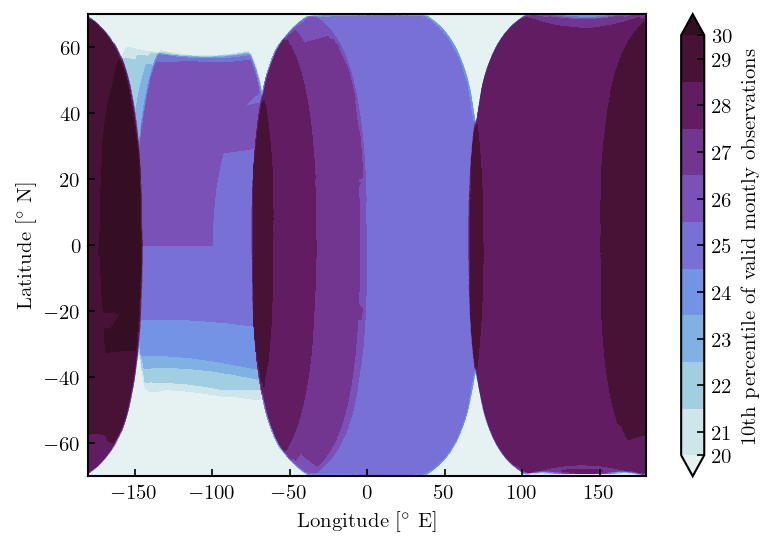

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
levels = np.linspace(20, 30, 11)
levels = 0.5 * (levels[1:] + levels[:-1])
m = ax.contourf(counts.longitude.data, counts.latitude.data, counts_p.data, levels=levels, extend="both")
ax.set_ylabel("Latitude [$^{\circ}$ N]")
ax.set_xlabel("Longitude [$^{\circ}$ E]")
cb = plt.colorbar(m, label="10th percentile of valid montly observations")
cb.ax.set_yticks(np.arange(20, 30.1))
fig.savefig("../figures/monthly_observations_1983_2000.pdf", bbox_inches="tight")

In [30]:
mask_24 = counts_p >= 24
dataset = xr.Dataset({
    "mask": mask_24
})
dataset.to_netcdf("/scratch/ccic_record/data/mask_24.nc")